In [1]:
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), './utils/'))
from data_processing import load_data_from_folder
from feature_engineering import extract_fft
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, MaxPool1D, Input, UpSampling1D
import keras.backend as K
from cnn_layers import Conv1DTranspose
import keras
import numpy as np
import seaborn as sns
from sklearn.preprocessing import scale
from obspy.signal.filter import bandpass
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from metrics import mae
from testing import create_array_score
import pandas as pd
from visualization import set_font_size

Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
import keras.backend.tensorflow_backend as ktf
import tensorflow as tf
def get_session(gpu_fraction=0.5):
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction,
                                allow_growth=True)
    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

ktf.set_session(get_session())

# Load data

In [4]:
df_ok = load_data_from_folder('./data/OK')

In [5]:
df_ng = load_data_from_folder('./data/NG')

In [6]:
print(df_ok.iloc[0]['acc'].shape)

(243938, 1)


# Feature Engineering

In [7]:
NFFT = 2048
FRAME_LEN = 4096
SLIDE_WINDOW = 128

In [42]:
extract_fft(df_ok, nfft=NFFT, frame_len=FRAME_LEN, slide_window=SLIDE_WINDOW)

In [43]:
extract_fft(df_ng)

# Preparing data for training and testing

In [44]:
train_data, test_data = train_test_split(df_ok.iloc[0]['fft'], test_size=0.2, random_state=42)
print(train_data.shape, test_data.shape)

(1499, 1024, 1) (375, 1024, 1)


# Create and Train Model

In [45]:
inputs = Input(shape=(1024, 1))
encoder = Conv1D(filters=128, kernel_size=5, strides=2, padding='same', activation='relu')(inputs)
encoder = MaxPool1D()(encoder)
encoder = Conv1D(filters=256, kernel_size=5, strides=2, padding='same', activation='relu')(encoder)
encoder = MaxPool1D()(encoder)
encoder = Conv1D(filters=512, kernel_size=5, strides=2, padding='same', activation='relu')(encoder)

decoder = Conv1DTranspose(encoder, filters=256, kernel_size=5, strides=2, padding='same', activation='relu')
decoder = UpSampling1D()(decoder)
decoder = Conv1DTranspose(decoder, filters=128, kernel_size=5, strides=2, padding='same', activation='relu')
decoder = UpSampling1D()(decoder)
outputs = Conv1DTranspose(decoder, filters=1, kernel_size=5, strides=2, padding='same', activation='relu')

model = Model(inputs, outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1024, 1)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 512, 128)          768       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 256, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 128, 256)          164096    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 64, 256)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 32, 512)           655872    
_________________________________________________________________
lambda_13 (Lambda)           (None, 32, 1, 512)        0         
__________

In [46]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mae')

In [47]:
history = model.fit(train_data, train_data, batch_size=32, epochs=5, validation_split=0.2)

Train on 1199 samples, validate on 300 samples
Epoch 1/5
1199/1199 [==============================] - 2s 2ms/step - loss: 0.6213 - val_loss: 0.5185
Epoch 2/5
1199/1199 [==============================] - 1s 798us/step - loss: 0.4647 - val_loss: 0.4094
Epoch 3/5
1199/1199 [==============================] - 1s 796us/step - loss: 0.3911 - val_loss: 0.3796
Epoch 4/5
1199/1199 [==============================] - 1s 796us/step - loss: 0.3693 - val_loss: 0.3681
Epoch 5/5
1199/1199 [==============================] - 1s 795us/step - loss: 0.3584 - val_loss: 0.3504


Text(0,0.5,'MAE')

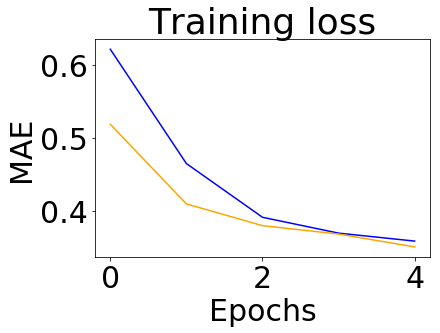

In [48]:
plt.plot(history.history['loss'], c='blue')
plt.plot(history.history['val_loss'], c='orange')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('MAE')

# Testing Model

In [49]:
scores = np.ndarray((0, 5))

In [50]:
y_pred = model.predict(train_data, batch_size=32)
train_score = mae(train_data, y_pred)     
score = create_array_score('Train', '97', 'Train', 0, train_score)
scores = np.vstack([scores, score])

In [51]:
y_pred = model.predict(test_data, batch_size=32)
score = mae(test_data, y_pred)     
score = create_array_score('97', '97', 'normal', 0, score)
scores = np.vstack([scores, score])

In [52]:
for i,row in df_ng.iterrows():
    y_pred = model.predict(row['fft'], batch_size=32)
    score = mae(row['fft'], y_pred)     
    score = create_array_score(row['id'], row['id'], row['label'], row['label_number'], score)
    scores = np.vstack([scores, score])

In [53]:
df_score = pd.DataFrame(scores)
df_score.columns = ['ID', 'Target', 'MAE', 'Label', 'label_number']
df_score['MAE'] = df_score['MAE'].astype('float')

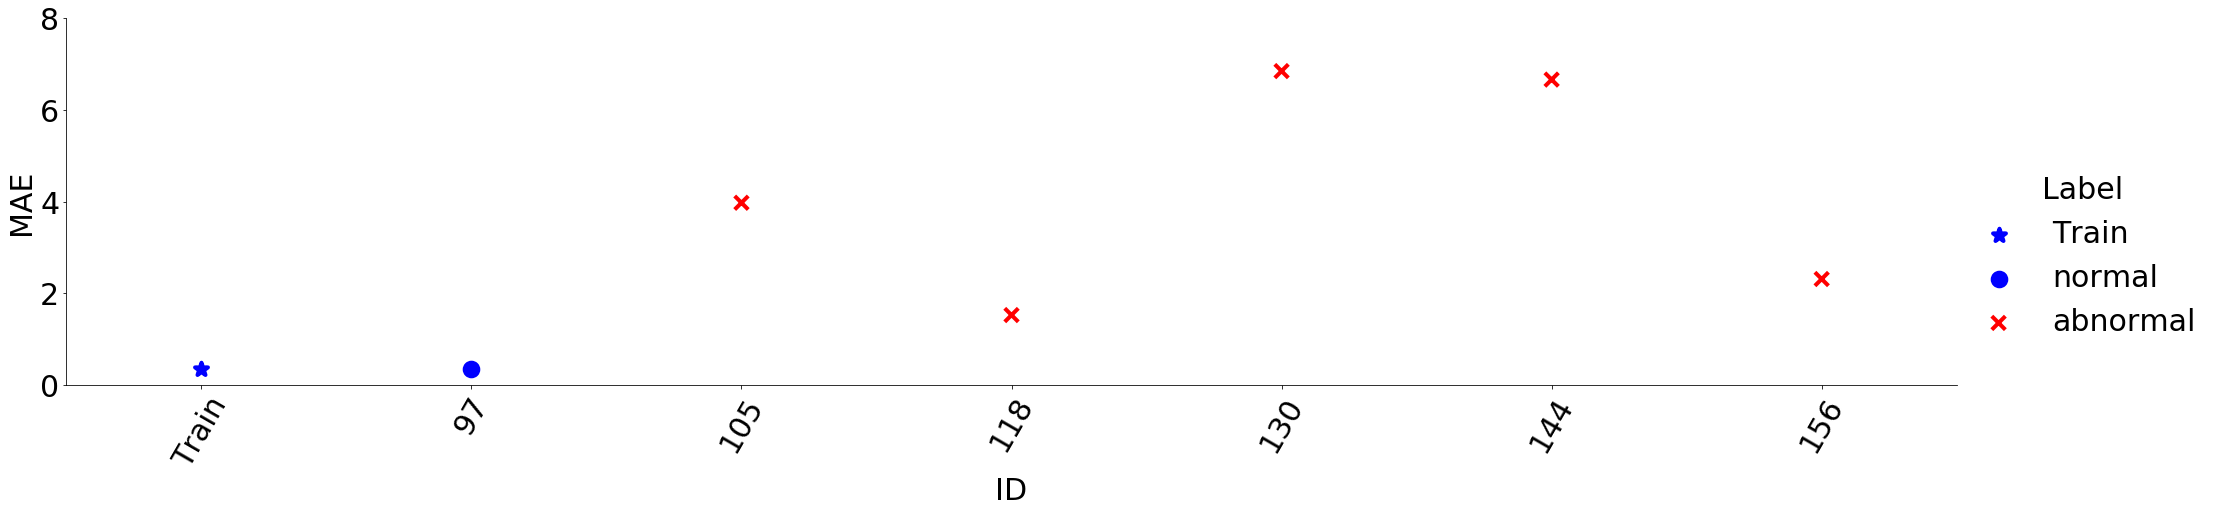

In [56]:
set_font_size(30)
    
g = sns.catplot(data=df_score, x='ID', y='MAE', kind='point', hue='Label', palette=['blue', 'blue', 'red'], 
                markers=['*', 'o','x'], aspect=4, height=7, join=False, ci=None, scale=2)
g.set_xticklabels(rotation=60)
plt.title('')
plt.ylim(0, 8)
plt.show()